# Pokemon Identifier

This is going to train a pokemon identifier that will be trained on several data sources

In [29]:
import os
import sys
import string
import datetime
import shutil
import argparse
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.preprocessing.image as preprocessing 
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from imutils import paths #used to get the paths of all images in a dir

In [30]:
import matplotlib.pyplot as plt

## Global Values

In [31]:
clearLogs = False
strNow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ENV = "windowsLocal"

#path to dataset directory
ENV_LOG_DIR = f"../Logs/{ENV}/"
SESSION_LOG_DIR = f"../Logs/{ENV}/{strNow}/"
CORE_DATASET = '../Datasets/Main/Images/'
TRAIN_DIR = '../Datasets/Main/Images/Train/'
VALIDATION_DIR = '../Datasets/Main/Images/Validation/'
# SAVE_DIR = os.path.join(SESSION_LOG_DIR, "Saves")
# CHECKPOINT_DIR = os.path.join(SAVE_DIR, "Checkpoints")
# FINAL_SAVE_DIR = os.path.join(SAVE_DIR, "Final")
if os.path.isdir('../Logs') is False:
    os.mkdir('../Logs')
if os.path.isdir(ENV_LOG_DIR) is False:
    os.mkdir(ENV_LOG_DIR)
if os.path.isdir(SESSION_LOG_DIR) is False: 
    os.mkdir(SESSION_LOG_DIR)

numCategories = len(os.listdir(TRAIN_DIR))

#amount of time to allot for training
trainTimeLimit = 0

#percentage of core dataset to use for training and testing
TRAIN_SPLIT = .9 

if clearLogs is True and os.path.isdir('../Logs') :
    shutil.rmtree('../Logs')
    
if os.path.isdir(CORE_DATASET) is False:
    print('DATASET NOT FOUND') 
    
if os.path.isdir(TRAIN_DIR) is False:
    print('TRAIN SET NOT FOUND')
                 
if os.path.isdir(VALIDATION_DIR) is False:
    print('VALIDATION SET NOT FOUND')

BATCH_SIZE = 300

NUM_EPOCHS = 10

IMAGE_HEIGHT = 70
IMAGE_WIDTH = 70
#normalization value that will be used for color channels
IMAGE_NORM_COLOR = 255 

### Data Pipeline Params

In [32]:
PIPE_USE_RAND_ZOOM = True
PIPE_RAND_ZOOM_AMT = (-0.5, 0.5)
PIPE_USE_CACHE = False
PIPE_RATIO_TRAIN = 0.75
PIPE_RATIO_VALID = 1 - PIPE_RATIO_TRAIN

### Training Params

In [33]:
NUM_NODES_IN_CONV = [128]
NUM_LAYERS_CONV = [3]
CONV_KERNEL_SIZE = (3,3)
REGULARIZER_USE = True
REGULARIZER_LEARNING_RATE = 0.01
USE_BATCH_NORMS = True

### Take command line arguments if any

In [34]:
if (len(sys.argv) > 0):
    print(sys.argv)
    listArgs = sys.argv
    for arg in listArgs: 
        splitArg = arg.split('=')
        if splitArg[0] == "timeLimit": 
            timeSplit = splitArg[1].split('.')
            if (len(timeSplit) == 3):
                hours = int(timeSplit[0])
                minutes = int(timeSplit[1])
                seconds = int(timeSplit[2])
                trainTimeLimit = (60*60*hours)+(60*minutes)+seconds
                print(f'time limit set to- {trainTimeLimit} seconds') 
        elif splitArg[0] == "epochs":
            numEpochs = int(splitArg[1])
        elif splitArg[0] == "cache":
            PIPE_USE_CACHE = bool(splitArg[1])
            print('Will utilize caching for dataset')
        elif splitArg[0] == "batchNorm":
            USE_BATCH_NORMS = bool(splitArg[1])

['/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py', '--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"b41aa9f9-f7e8-416c-b821-4a6f211c836e"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/tmp/tmp-262fb859Be30x8X.json']


## Train

### Create Datasets with TF.Data

In [35]:


# #generate training and testing split 
# i = int(len(imagePaths) * 

# datasets = [
#     ("training", trainPaths, TRAIN_DIR),
#     ("validation", validationPaths, VALIDATION_DIR)
# ]

In [36]:
def loadImages(imagePath):
    #encode the image
    # tf.print(imagePath)
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_png(image, channels=4)
    image = tf.image.resize_with_pad(image, IMAGE_HEIGHT, IMAGE_WIDTH)
    image = tf.cast(image, tf.float32)
    
    #encode the label for the image
    labelParts = tf.strings.split(imagePath, os.sep)
    oneHot = labelParts[-2] == classNames 
    return (image, tf.argmax(oneHot))

In [37]:
seqAugment = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/255),
    tf.keras.layers.RandomZoom(
        height_factor=PIPE_RAND_ZOOM_AMT, #zoom in by random ammount from +20% to +30%
        width_factor=PIPE_RAND_ZOOM_AMT, 
        fill_mode='constant', 
        fill_value=0)
])

In [38]:
trainPaths = list(paths.list_images(TRAIN_DIR))
valPaths = list(paths.list_images(VALIDATION_DIR))
trainLabels = [p.split(os.path.sep)[-2] for p in trainPaths] #gather labels from dirs 
classNames = np.array(sorted(trainLabels))
classNames = np.unique(classNames)

imagePaths = list(paths.list_images(CORE_DATASET))
random.seed(32)
random.shuffle(imagePaths)

numTrain = int(len(imagePaths) * PIPE_RATIO_TRAIN)
numVal = int(len(imagePaths) * PIPE_RATIO_VALID)

#define pipelines 
#training dataset 
print(numTrain)
trainDS = tf.data.Dataset.from_tensor_slices(imagePaths[:numTrain])
trainDS = (trainDS
           .shuffle(len(trainPaths)) #shuffle all the images 
           .map(loadImages, num_parallel_calls=AUTOTUNE) #read images from disk 
           .map(lambda x, y: (seqAugment(x), y), num_parallel_calls=AUTOTUNE)
        )
if PIPE_USE_CACHE is True: 
    trainDS = trainDS.cache()
trainDS = (trainDS
           .batch(BATCH_SIZE) #batch size
           .prefetch(AUTOTUNE)
          )

#validation dataset
valDS = tf.data.Dataset.from_tensor_slices(imagePaths[numTrain :])
valDS = (valDS
         .map(loadImages, num_parallel_calls=AUTOTUNE))
if PIPE_USE_CACHE is True:
    valDS = valDS.cache()
valDS = (valDS
         .batch(BATCH_SIZE)
         .prefetch(AUTOTUNE))

543696


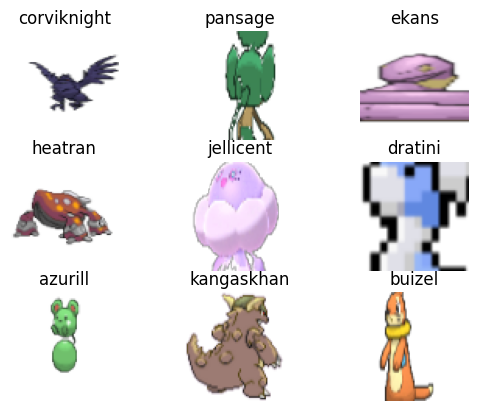

In [39]:
# print(trainPaths[15061])
for images, labels in trainDS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()*255).astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")
    plt.show()

### Create Datagenerators

### Define Model

In [40]:
for numConvLayers in NUM_LAYERS_CONV:
    for convNodes in NUM_NODES_IN_CONV:
        for convKernelSize in CONV_KERNEL_SIZE:
            #create necessary log directories
            local_container_dir = os.path.join(SESSION_LOG_DIR, f"cl{numConvLayers}.cn{convNodes}.ckern{convKernelSize}")
            local_tensorlogs_dir = os.path.join(local_container_dir, 'fit/')
            local_save_dir = os.path.join(local_container_dir, 'saves/')
            local_checkpoint_dir = os.path.join(local_save_dir, 'checkpoints/')
            local_finalsave_dir = os.path.join(local_save_dir, 'final/')

            if os.path.isdir(local_container_dir) is False: 
                os.mkdir(local_container_dir)
            if os.path.isdir(local_tensorlogs_dir) is False: 
                os.mkdir(local_tensorlogs_dir)
            if os.path.isdir(local_save_dir) is False:
                os.mkdir(local_save_dir)
            if os.path.isdir(local_checkpoint_dir) is False:
                os.mkdir(local_checkpoint_dir)
            if os.path.isdir(local_finalsave_dir) is False: 
                os.mkdir(local_finalsave_dir)

            #write summary to file 
            infoFile = os.path.join(local_container_dir, "into.txt")
            with open(infoFile, 'w') as file: 
                file.write(f"Number of convolution layers: {numConvLayers} \r")
                file.write(f"Number of nodes per convolution layer: {convNodes} \r")
                file.write(f"Input size expected: {IMAGE_WIDTH}, {IMAGE_HEIGHT}\r")
                file.write(f"Epochs: {NUM_EPOCHS}\r")
                file.write(f"Regularizers in use? {REGULARIZER_USE}\r")
                file.write(f"Regularizer learning rate: 0.01\r")
                file.write(f"Conv kernel size: {convKernelSize}\r")
                file.close()

            #cleanup from last round 
            tf.keras.backend.clear_session()

            #define the model 
            model = tf.keras.models.Sequential()
            for i in range(numConvLayers):
                if REGULARIZER_USE is True:
                    model.add(tf.keras.layers.Conv2D(int(convNodes),
                                                        convKernelSize,
                                                        activation='relu',
                                                        kernel_regularizer=regularizers.l2(REGULARIZER_LEARNING_RATE)))
                else:
                    model.add(tf.keras.layers.Conv2D(int(convNodes), convKernelSize, activation='relu'))
                if USE_BATCH_NORMS is True:
                    model.add(tf.keras.layers.BatchNormalization())
                    
                #add additional properties to conv layers
                model.add(tf.keras.layers.MaxPool2D((2,2)))
                if USE_BATCH_NORMS is True:
                    model.add(tf.keras.layers.BatchNormalization())

            #flatten out 
            model.add(tf.keras.layers.Flatten())
            model.add(tf.keras.layers.Dense(512, activation='relu'))
            
            if USE_BATCH_NORMS is True: 
                model.add(tf.keras.layers.BatchNormalization())
                
            model.add(tf.keras.layers.Dense(len(classNames), activation='softmax'))
            
            model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=RMSprop(learning_rate=1e-4),
                    metrics=['accuracy'])
            
            #create callbacks as necessary
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=local_checkpoint_dir, 
                                                                    save_weights_only=True, 
                                                                    verbose=1)
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=local_tensorlogs_dir,                        
                                                                histogram_freq=1, 
                                                                write_graph=True, 
                                                                write_images=False, 
                                                                embeddings_freq=1, 
                                                                profile_batch='1,5')
                
            time_stopping_callback = None
            history = None
            
            if (trainTimeLimit != 0):
                #shorten the time limit to allow for post training data processing
                trainTimeLimit = trainTimeLimit - (60*5) 
                time_stopping_callback = tfa.callbacks.TimeStopping(seconds=trainTimeLimit, verbose=1)
                history = model.fit(trainDS, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=valDS,
                                    callbacks=[tensorboard_callback, checkpoint_callback, time_stopping_callback])
            else:
                #no time limit callback
                history = model.fit(trainDS, 
                            epochs=NUM_EPOCHS, 
                            validation_data=valDS,
                            callbacks=[tensorboard_callback, checkpoint_callback])

            #save model and record completion in info file
            model.save(local_finalsave_dir)
            with open(infoFile, 'a') as file: 
                file.write('Training Complete')
                file.close()
            

Epoch 1/10
1813/1813 [==============================] - ETA: 0s - loss: 2.9691 - accuracy: 0.7537
Epoch 1: saving model to ../Logs/windowsLocal/20220424-204659/cl3.cn128.ckern3/saves/checkpoints/
1813/1813 [==============================] - 854s 469ms/step - loss: 2.9691 - accuracy: 0.7537 - val_loss: 670.4006 - val_accuracy: 0.1376
Epoch 2/10
1813/1813 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.9751
Epoch 2: saving model to ../Logs/windowsLocal/20220424-204659/cl3.cn128.ckern3/saves/checkpoints/
1813/1813 [==============================] - 769s 424ms/step - loss: 0.4773 - accuracy: 0.9751 - val_loss: 736.6712 - val_accuracy: 0.1192
Epoch 3/10
1812/1813 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9854
Epoch 3: saving model to ../Logs/windowsLocal/20220424-204659/cl3.cn128.ckern3/saves/checkpoints/
1813/1813 [==============================] - 775s 427ms/step - loss: 0.1863 - accuracy: 0.9854 - val_loss: 1212.4829 - val_accuracy: 0

#### Zip Logs For Download

In [ ]:
shutil.make_archive('Logs', 'zip', '../Logs')